<a href="https://colab.research.google.com/github/wkweigel/NotebookExamples/blob/main/PeptoidGeneration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook demonstrates the generation of peptoid smiles from amine building blocks (monomers).
* The amine monomers are input as a dictionary of smiles keyed by single-letter code for each monomer.
* The generator accepts a string representing the sequence of the desired peptoid.
* Peptoid generation is performed using iterative synthesis cycles akin to what is done in real-life:
    1. Amine Displacement: The amine monomer displaces a haloacetic acid to yield an a-amino substituted intermediate.
    2. Amide Coupling: The a-amino intermediate is coupled with the next unit of haloacetic acid.

To prevent cross reactivity, the smiles of the monomers need to protected:
* Amines not intended as the reaction center need to be Boc protected.
* Carboxylic acids must be protected as the t-butyl ester.

The generator will perform a final global deprotection of these groups.


Install libraries and source repositories into colab

In [1]:
!pip install rdkit tqdm
!git clone https://github.com/wkweigel/PeptoidGeneration.git

import sys
sys.path.insert(0,'/content/PeptoidGeneration')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 18.6 MB/s eta 0:00:00
Cloning into 'PeptoidGeneration'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 33 (delta 16), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (33/33), 206.05 KiB | 4.12 MiB/s, done.
Resolving deltas: 100% (16/16), done.


#### Imports and input params

In [2]:
from rdkit import Chem
from rdkit.Chem import Draw, rdDepictor
from itertools import product
from tqdm.notebook import tqdm_notebook
import pandas as pd
import random
from PeptoidGeneration.Reactions import Reaction
from Utils import generate_peptoid_strings, peptoid_smiles_from_string


# Dictionary of amine monomers
peptoid_dict={
'L' : 'CC(C)CN',
'F' : 'NCc1ccccc1',
'P' : 'NCc1ccncc1',
'S' : 'CC(C)(C)OCCN',
'I' : 'CC(C[C@H](N)C(OC(C)(C)C)=O)C',
'D' : 'CC(C)(C)OC(CN)=O',
'N' : 'Nc1cc2ccccc2cc1',
'A' : 'N[C@H](C(OC(C)(C)C)=O)Cc1nc[nH]c1',
'K' : 'CC(C)(C)OC(NCCCCN)=O',
'Y' : 'CC(C)(C)Oc1ccc(CN)cc1',
'H' : 'CC(C)(C)OC(n1cnc(CN)c1)=O',
'W' : 'CC(C)(C)OC(n1c(cccc2)c2c(CN)c1)=O',
'R' : 'CC(C)(OC(N/C(N(C(OC(C)(C)C)=O)CCCN)=N/C(OC(C)(C)C)=O)=O)C',
'G' : 'NC(OC(C)(C)C)=P', #Uses a modified carbamate so nitrogen is not ignored by reaction SMARTS
'X' : 'O=C(CBr)[C@@H]1CCCN1', #Used for proline-containing pseudo-peptoids
'B' : 'O=C(CBr)OC(C)(C)C'
}

# Parameters
n = 50  # Number of unique strings
length = 10  # Length of each string
monomers = ['S', 'D', 'L', 'K', 'Y', 'H', 'W', 'R', 'F', 'P', 'X', 'G'] # The possible peptoid monomers

#### Preview the monomers from the peptoid_dict

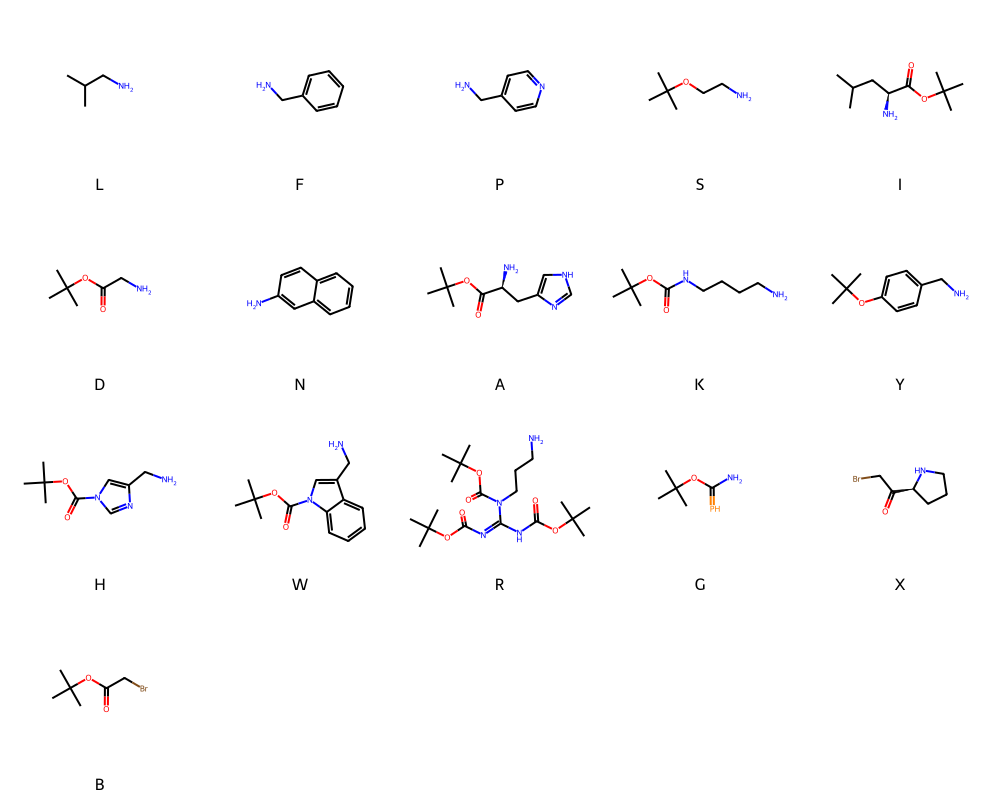

In [3]:
peptoid_smiles = list(peptoid_dict.values())

mol_list=[]
for smi in peptoid_smiles:
    mol_list.append(Chem.MolFromSmiles(smi))

Draw.MolsToGridImage(mol_list, legends= list(peptoid_dict.keys()), molsPerRow = 5)

#### Generate peptoid strings (Option 1)
This will generate ALL possible peptoid combinations of the specified length.
* depending of the number of possible monomers, the length should not exceed 4 or 5 to keep the total count reasonable.   

In [8]:
# Generate ALL combinations for peptiod of length n
peptoid_strings = [''.join(seq) for seq in product(monomers, repeat=4)] #keeping the repeat value at 5 or below is recommend

#### Generate peptoid strings (Option 2)
This will generate n RANDOM peptoid combinations of the specified length
* use for longer peptoid lengths

In [4]:
# Generate n unique strings
peptoid_strings = generate_peptoid_strings(n, length, monomers)

#### Preview the peptoid strings

In [9]:
# Preview the peptoid strings
for s in peptoid_strings[:10]:
    print(s)

SSSS
SSSD
SSSL
SSSK
SSSY
SSSH
SSSW
SSSR
SSSF
SSSP


#### Assemble the peptoid smiles and output to a .csv file

In [6]:
#Create an empty dict for holding the final peptoid products
final_peptoids={}

#Convert the peptoid strings to smiles and store results in a dictionary
for string in tqdm_notebook(peptoid_strings):
    peptoid_smiles = peptoid_smiles_from_string(string, peptoid_dict)
    final_peptoids[string]=peptoid_smiles

result_df=pd.DataFrame(final_peptoids.items(), columns=['Code', 'Smiles'] )

result_df.to_csv('peptoid_smiles.csv')

  0%|          | 0/50 [00:00<?, ?it/s]

#### Preview the final peptoid structures

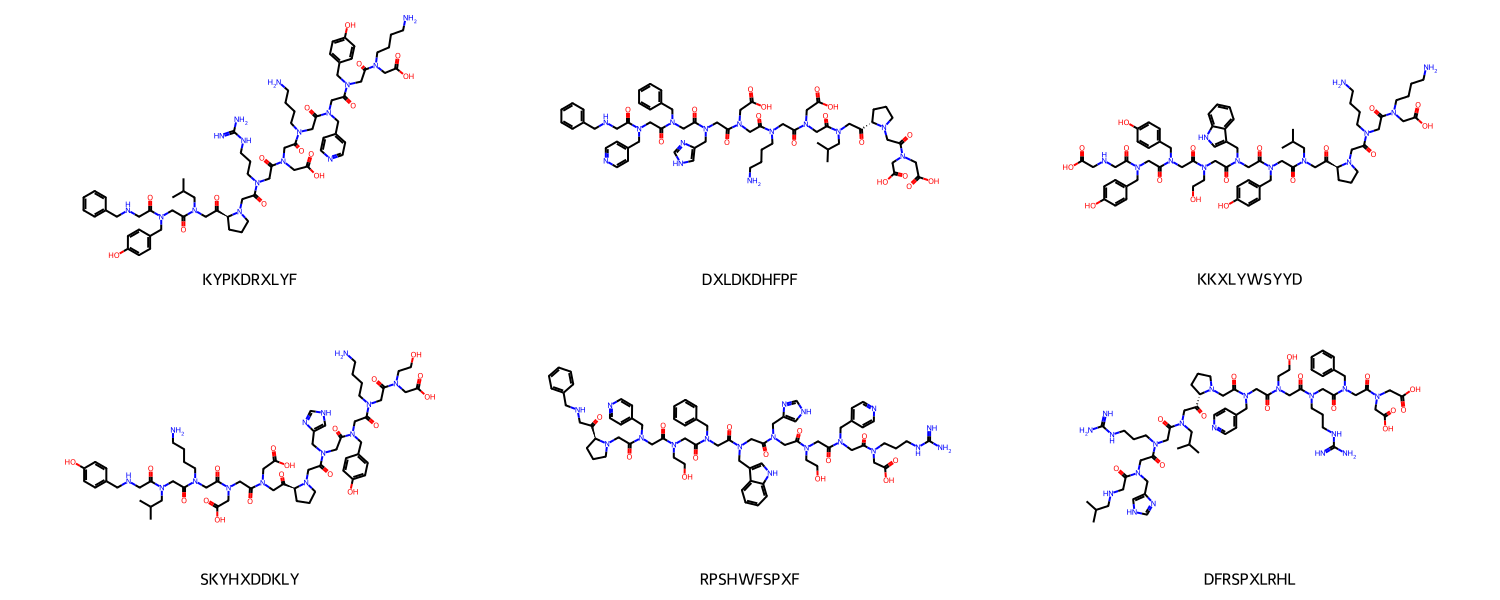

In [7]:
#Get some results to preview
preview_df = result_df.head(6)
preview_codes = preview_df.Code.to_list()
preview_smiles = preview_df.Smiles.to_list()
preview_mols = [Chem.MolFromSmiles(smi) for smi in preview_smiles]

#Generate coordinates and orient canonically
rdDepictor.SetPreferCoordGen(True)
for mol in preview_mols:
    rdDepictor.Compute2DCoords(mol)


Draw.MolsToGridImage(preview_mols, legends= preview_codes, molsPerRow = 3, subImgSize=(500,300))